## CNN Part

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Importing the required libraries

In [2]:
df = pd.read_csv("C:/Users/Haneesh/Downloads/Tesla/HistoricalData_1680617366028.csv")
df

,Date,Close/Last,Volume,Open,High,Low
0,04/03/2023,$194.77,169545900,$199.91,$202.6897,$192.20
1,03/31/2023,$207.46,170222100,$197.53,$207.79,$197.20
2,03/30/2023,$195.28,110252200,$195.58,$197.33,$194.42
3,03/29/2023,$193.88,123660000,$193.13,$195.29,$189.44
4,03/28/2023,$189.19,98654640,$192.00,$192.35,$185.43
...,...,...,...,...,...,...
246,04/08/2022,$341.83,55013706,$347.7366,$349.48,$340.8116
247,04/07/2022,$352.42,79447058,$350.7966,$358.8633,$340.5133
248,04/06/2022,$348.5866,89348559,$357.8233,$359.6666,$342.5666
249,04/05/2022,$363.7533,80075018,$378.7666,$384.29,$362.4333


I am reading a CSV file using pandas library and storing it in a dataframe called df

In [3]:
df = df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

It drops four columns ('Open, High, Low, Volume') from the data frame using drop method and specifying the axis=1 parameter, which means it will drop columns rather than rows.

It converts the 'Date' column to a datetime format using Datetime function.

It sets the index of the Dataframe to be the Date column using set_index method.

In [4]:
# Remove dollar signs and commas from the Close column
df['Close/Last'] = df['Close/Last'].str.replace('$', '')
df['Close/Last'] = df['Close/Last'].str.replace(',', '')

# Convert the Close column to float data type
df['Close/Last'] = df['Close/Last'].astype(float)

C:\Users\Haneesh\AppData\Local\Temp\ipykernel_2956\3940862722.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close/Last'] = df['Close/Last'].str.replace('$', '')


These replaces the $ and Commas symbols in the 'close/last' column with an empty string.

In [5]:
n_steps = 60

train_data = []
target_data = []

for i in range(n_steps, len(df)-1):
    X = df['Close/Last'][i-n_steps:i].values.reshape(n_steps, 1)
    y = df['Close/Last'][i+1]
    train_data.append(X)
    target_data.append(y)

train_data = np.array(train_data)
target_data = np.array(target_data)


print(train_data.shape)   
print(target_data.shape) 

(190, 60, 1)
(190,)


It creates a sliding window of historical data to use as input features and target variable for a time series forecasting task. It collects the input features and target variable in separate lists which are then transformed into NumPy arrays.

In [6]:
scaler = MinMaxScaler()

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1])
train_data = scaler.fit_transform(train_data)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
target_data = scaler.fit_transform(target_data.reshape(-1, 1))

I am applying MinMax scaling to the input and output data for normalization before training a deep learning model. This type of scaling is often used for deep learning models as it helps to accelerate convergence and improve the performance of the model.

In [32]:
def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 1])
        Y.append(data[i+lookback, 1])
    return np.array(X), np.array(Y)

It prepares data for a time series forecasting model by creating input-output pairs of historical data, where the input features consist of lookback number of previous time steps of a single time series and the target variable is the next time step value.

In [33]:
lookback = 60
batch_size = 30
epochs = 100

lookback - the model will use the previous 60 time steps as input features to predict the next value.
batchsize - the model will use 30 samples at a time to make weight updates in the training process.
epochs - the model will be trained on the entire dataset 100 times.

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data, target_data, test_size=0.2, shuffle=False)

By splitting the dataset into training and test sets, we can train the time series forecasting model on a subset of the data and evaluate its performance on a set of data that the model has not seen before. This is important for assessing the accuracy and generalizability of the model.

In [35]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

It prepare the input features for use in a deep learning model by reshaping them into a 3D array format. This is necessary because many deep learning models expect input data to be in a specific shape, so data must be preprocessed to ensure that it is in the correct format before training the model.

In [36]:
# Build the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=60, kernel_size=3, activation='relu', input_shape=(lookback, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(60, activation='relu'))
model.add(Dense(1))

This is suitable for time series data since it can learn both temporal and spatial features of the dataset. By using a 1D convolutional layer, the model can learn patterns that occur across time in the input data, while the pooling layer and dense layers enable the model to extract and analyze higher-level features of the data.

In [37]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

It configures the CNN model to use the mean squared error loss function and the Adam optimizer during the training process. By setting the loss and optimizer, the model is ready to be trained on the training data.

In [38]:
print(X_train.shape)
print(Y_train.shape)

(152, 60, 1)
(152, 1)


In [39]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=30, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/100
6/6 - 2s - loss: 0.0601 - val_loss: 0.0353 - 2s/epoch - 271ms/step
Epoch 2/100
6/6 - 0s - loss: 0.0184 - val_loss: 0.0273 - 97ms/epoch - 16ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0095 - val_loss: 0.0134 - 96ms/epoch - 16ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0100 - val_loss: 0.0570 - 84ms/epoch - 14ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0120 - val_loss: 0.0102 - 92ms/epoch - 15ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0074 - val_loss: 0.0348 - 100ms/epoch - 17ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0062 - val_loss: 0.0093 - 99ms/epoch - 16ms/step
Epoch 8/100
6/6 - 0s - loss: 0.0070 - val_loss: 0.0378 - 102ms/epoch - 17ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0074 - val_loss: 0.0076 - 116ms/epoch - 19ms/step
Epoch 10/100
6/6 - 0s - loss: 0.0062 - val_loss: 0.0185 - 106ms/epoch - 18ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0057 - val_loss: 0.0188 - 94ms/epoch - 16ms/step
Epoch 12/100
6/6 - 0s - loss: 0.0052 - val_loss: 0.0120 - 92ms/epoch - 15ms/step
Epoch 13/100
6/6 - 0s - loss: 0.00

It trains the CNN model on the training data and evaluates its performance on the validation data for 100 epochs with a batch size of 30 and displays output at every epoch.

In [15]:
loss = model.evaluate(X_test, Y_test)
print('Test Loss:', loss)

2/2 [==============================] - 0s 16ms/step - loss: 0.0071
Test Loss: 0.00708149466663599


 The loss (or error) of the model on the test set, which is a measure of how well the model generalizes to new, unseen data. The lower the loss, the better the model's performance on the test set.

In [16]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

2/2 [==============================] - 0s 0s/step


It compare the predicted output values with the original, true target values, and evaluate the performance of the trained machine learning model.

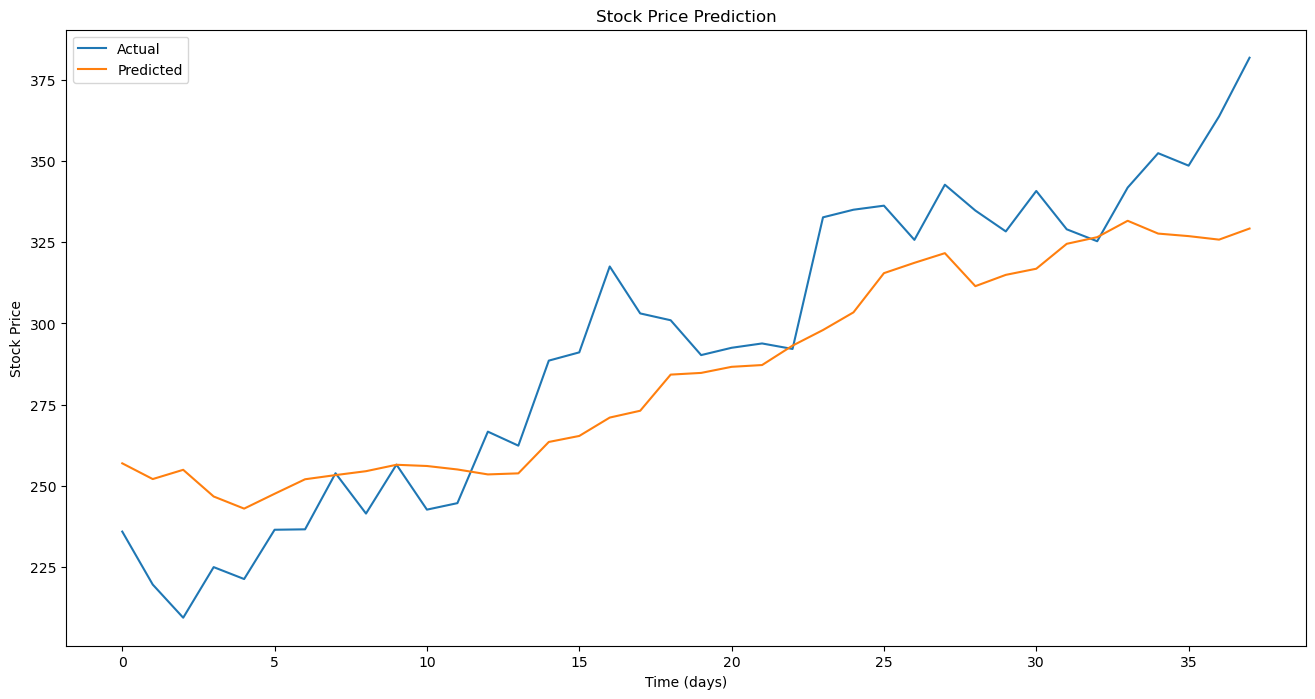

In [17]:
actual_values = scaler.inverse_transform(target_data)

# Plot the actual and predicted values
actual_values = scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

It used to obtain the actual target values (i.e., true stock prices) in their original scale. Plot function is used to plot the actual stock prices and the predicted values.The plot enables us to visualize the goodness of fit of the predicted values and helps in comparing the predicted values to the actual values.

In [40]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

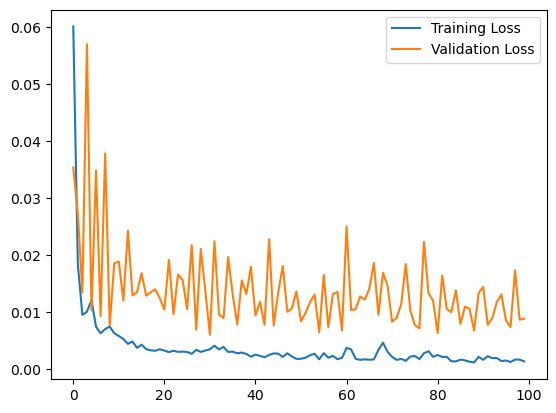

In [41]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

## Evaluating model performance

In [18]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

2/2 [==============================] - 0s 0s/step


It compare the predicted output values with the original, true target values, and evaluate the performance of the trained machine learning model.

In [19]:
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

actual target values that were used to evaluate the performance of the trained machine learning model.

In [20]:
mae = mean_absolute_error(Y_test_inv, predictions)
rmse = mean_squared_error(Y_test_inv, predictions, squared=False)
r2 = r2_score(Y_test_inv, predictions)

The mean absolute error is a metric that measures the average absolute difference between the actual and predicted values. It calculates the mean of the sum of the absolute difference between the predicted and the actual values. The mean absolute error is a commonly used metric for regression problems, and it is expressed in the same units as the target variable.
The average squared difference between the predicted and actual values. Root mean squared error is a metric used to penalize large errors more than smaller errors as compared to mean absolute error.
The R-squared metric, which is a statistical measure that indicates how well the predictions match the actual target values.
These three metrics are useful in understanding the performance of the machine learning model and comparing it to other models.

In [21]:
print('MAE:', mae)
print('RMSE:', rmse)
print('R2 Score:', r2)

MAE: 18.945935584781047
RMSE: 23.03369849848556
R2 Score: 0.7567135246184169


    The mean absolute error (MAE) is a measure of how well the machine learning model has been able to predict the target value. A lower MAE indicates better performance of the model. In this case, the MAE value is 22.0135, which means that, on average, the actual stock prices differed from the predicted prices by approximately $22.01 USD.
    The root mean squared error (RMSE) of a machine learning model is another measure of how well the model has been able to predict the target value. Like the MAE, a lower value of RMSE also indicates better performance of the model. The RMSE in this case is 26.6630, which is an indication that the models predictions deviate from the actual values by roughly $26.66 USD on average.
    The R2 value for this model is 0.6740, which indicates that the model explains 67.40% of the variance in the target variable.

## Hyperparameter Tuning

In [22]:
def create_model(filters1, kernel_size1, filters2, kernel_size2, dense1, dense2, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters=filters1, kernel_size=(kernel_size1, 1), activation='relu', input_shape=(lookback, 1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(filters=filters2, kernel_size=(kernel_size2, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Flatten())
    model.add(Dense(dense1, activation='relu'))
    model.add(Dense(dense2, activation='relu'))
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

A Keras Sequential model that uses a combination of convolutional, pooling, and dense layers to perform regression analysis on input data that has a temporal structure(data that varies over time).
The function compiles the model using the mean squared error (MSE) loss function and the SGD optimizer with the specified learning rate.

In [23]:
model = KerasRegressor(build_fn=create_model, verbose=0)

C:\Users\Haneesh\AppData\Local\Temp\ipykernel_2956\3022883795.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


 This sets up a KerasRegressor object model that can be used for training regression models using the specific architecture defined in the create_model function.

In [24]:
param_grid = dict(filters1=[32, 64, 96], kernel_size1=[3, 5],filters2=[32, 64, 96],kernel_size2=[3, 5],dense1=[32, 64, 96],dense2=[16, 32],learning_rate=[0.01, 0.001])

It is a common tool used in hyperparameter tuning (a way to find the optimal combination of hyperparameters for a machine learning model).
It builds and train the necessary combinations of the model using different hyperparameter values in order to find the optimal combination of hyperparameters that leads to optimal model performance.

In [25]:
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

scoring parameter sets the score function that should be used to evaluate the candidate model hyperparameters. The 'neg_mean_squared_error' value used in this code means that the mean squared error (MSE) is used to evaluate model performance, and the output scores will be negative. The negation is due to the fact that the optimization problem solved within the grid search is a minimization.

In [26]:
grid_result = grid.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1), Y_train)

fit() - GridSearchCV that starts the search process by fitting the CNN model to the training data using each combination of hyperparameters specified in the grid.
grid_result object that contains the results of the grid search, such as the best score and best set of hyperparameters found.

In [27]:
predictions = grid_result.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1))

predict() -  is a method of the grid_result object that applies the trained CNN model to the test dataset and generates predictions for each sample in the dataset.
The output of the function is an array of predicted values for the target variable based on the input features.
The predicted target variable values for the test dataset based on the hyperparameters that were selected during the grid search.

In [28]:
actual_values = scaler.inverse_transform(target_data)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

scaler object to transform the predicted and actual target variable values back to their original scale. previously defined to scale the input and output data for the CNN model. This scaler was used to transform the target variable values before training the model, and now its being used to invert this transformation on the predicted and actual values after making predictions on test data.
An inverse transformation of the standardized target variable values back to their unstandardized values.
The original target variable values for the test dataset, back to its original scale.
The -1 parameter specifies that the number of rows of the resulting array should be automatically determined based on the size of the input array, while the 1 specifies the number of columns.
The predicted target variable values in their original units (e.g., dollars for a finance dataset) instead of the scaled unit used for training.

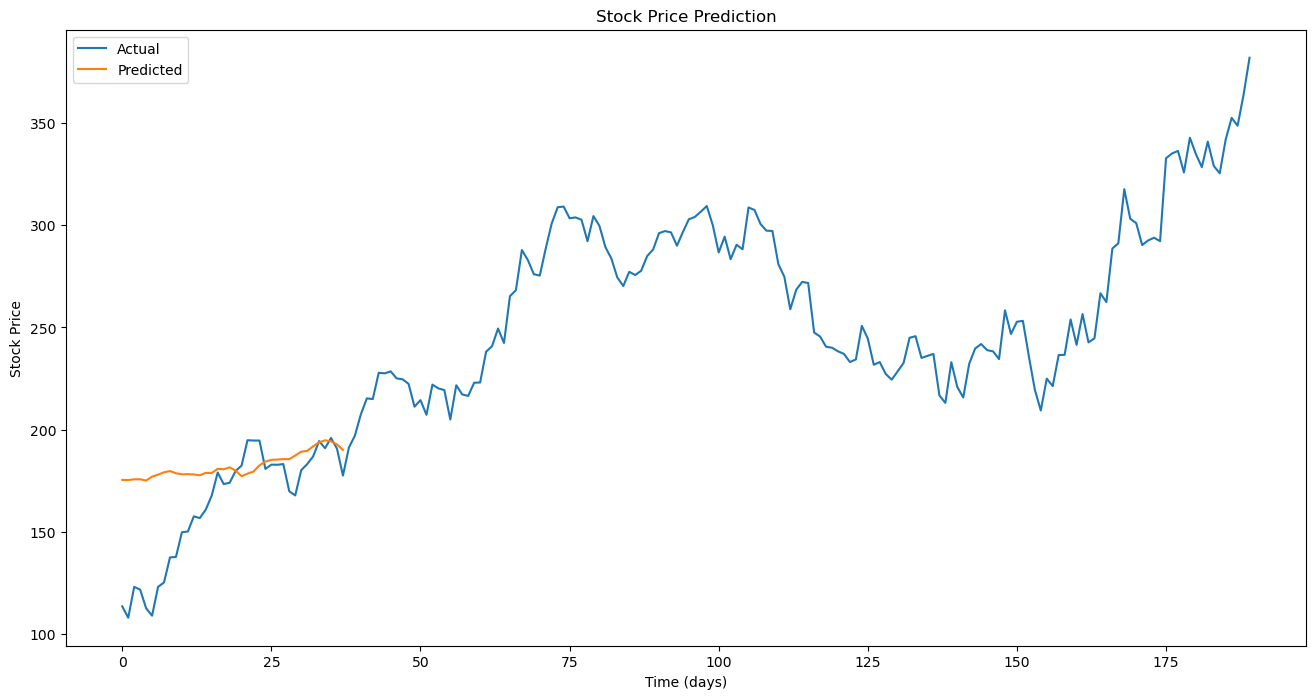

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

The actual and predicted values of the target variable (i.e., the stock price) on a line chart to visualize the performance of the model in predicting the future price movements.

In [30]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.084260 using {'dense1': 64, 'dense2': 32, 'filters1': 64, 'filters2': 64, 'kernel_size1': 5, 'kernel_size2': 3, 'learning_rate': 0.01}


The best mean score obtained during the grid search process was -0.083651. This indicates that the model has performed well.